In [1]:
import requests
import json
import time
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as  plt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./sample data/Metrics-2.csv')
df = df.set_index('Time')

In [3]:
print(df.head())
df.shape

                Requests_Sum
Time                        
03/07/22 22:20           585
03/07/22 22:21           706
03/07/22 22:22           675
03/07/22 22:23           561
03/07/22 22:24           735


(10080, 1)

In [4]:
train_split = int(len(df)*0.80)
val_split = int(len(df)*0.15) + train_split

In [6]:
train_df = df[:train_split]
val_df = df[train_split:val_split]
test_df = df[val_split:]
train_df.shape,val_df.shape,test_df.shape

((8064, 1), (1512, 1), (504, 1))

In [7]:
minmax = preprocessing.MinMaxScaler()
minmax.fit(train_df)

MinMaxScaler()

In [8]:
train_arr = minmax.transform(train_df)
test_arr = minmax.transform(test_df)
val_arr = minmax.transform(val_df)
# train_arr = np.array(train_df)
# test_arr = np.array(test_df)
# val_arr = np.array(val_df)


In [9]:
train_arr.shape, val_arr.shape, test_arr.shape

((8064, 1), (1512, 1), (504, 1))

In [12]:
def create_dataset(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [13]:
STEPS = 5
x_train, y_train = create_dataset(train_arr,STEPS)
x_val, y_val = create_dataset(val_arr,STEPS)
x_test, y_test = create_dataset(test_arr,STEPS)
x_train.shape, y_train.shape,x_val.shape, y_val.shape,x_test.shape, y_test.shape

((8059, 5, 1),
 (8059, 5, 1),
 (1507, 5, 1),
 (1507, 5, 1),
 (499, 5, 1),
 (499, 5, 1))

In [16]:
x_val[0],y_val[0]

(array([[0.37676439],
        [0.42453855],
        [0.54288817],
        [0.57437568],
        [0.50380022]]),
 array([[0.42453855],
        [0.54288817],
        [0.57437568],
        [0.50380022],
        [0.38653637]]))

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import RootMeanSquaredError

n_features = 1

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(STEPS, n_features)))
model.add(Dense(units = 5)) 
model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mse')

In [45]:
mc = ModelCheckpoint('./models',save_best_only=True)

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4,517
Trainable params: 4,517
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,callbacks=[mc])

Epoch 1/10
252/252 [==============================] - 3s 9ms/step - loss: 0.0261 - val_loss: 0.0038
Epoch 2/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 3/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/10
252/252 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/10
252/252 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/10
252/252 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0015

In [49]:
from tensorflow.keras.models import load_model
model=load_model('./models/')

In [50]:
train_yhat = model.predict(x_train).flatten()
train_results = pd.DataFrame({'yhat':train_yhat,'actuals':y_train.flatten()})
train_yhat.shape

252/252 [==============================] - 0s 1ms/step


(40295,)

In [55]:
model.predict(x_train[1].reshape(-1,5,1))

1/1 [==============================] - 0s 16ms/step


array([[0.640672  , 0.59685934, 0.7160393 , 0.73529303, 0.6956199 ]],
      dtype=float32)

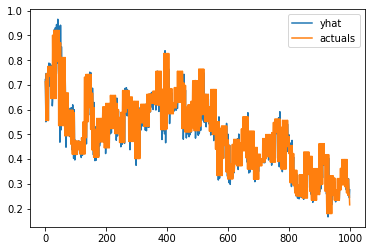

In [51]:
plt.plot(train_results['yhat'][:1000])
plt.plot(train_results['actuals'][:1000])
plt.legend(['yhat','actuals'])

In [26]:
val_yhat = model.predict(x_val).flatten()
val_results = pd.DataFrame({'yhat':val_yhat,'actuals':y_val.flatten()})

48/48 [==============================] - 0s 1ms/step


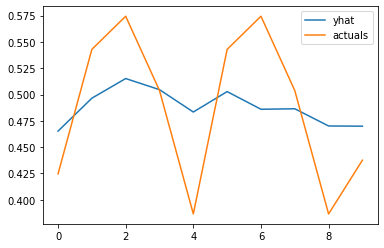

In [27]:
plt.plot(val_results['yhat'][:10])
plt.plot(val_results['actuals'][:10])
plt.legend(['yhat','actuals'])

In [28]:
test_yhat = model.predict(x_test).flatten()
test_results = pd.DataFrame({'yhat':test_yhat,'actuals':y_test.flatten()})

16/16 [==============================] - 0s 1ms/step


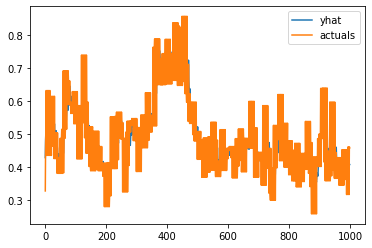

In [29]:
plt.plot(test_results['yhat'][:1000])
plt.plot(test_results['actuals'][:1000])
plt.legend(['yhat','actuals'])

In [30]:
def predict_steps(first_values,steps=10):
    f = first_values
    print(f)
    main_values = first_values
    for i in range(steps):
        x_input = np.array(f)
        x_input = x_input.reshape((1, STEPS, n_features))
        yhat = model.predict(x_input, verbose=0)
        yhat = yhat.flatten()[0]
        main_values.append(yhat)
        f = f[-4:]
        f.append(yhat)
    return(main_values)

In [41]:
first_values = list(test_arr[:STEPS].flatten())
yhat_arr = predict_steps(first_values,steps=len(test_arr)-STEPS)
len(yhat_arr)

[0.3984799131378936, 0.3279044516829533, 0.46688382193268185, 0.5320304017372421, 0.6319218241042346]


504

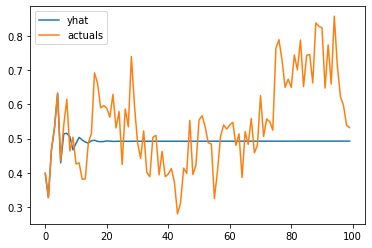

In [43]:
check = pd.DataFrame({'actuals':test_arr.flatten(),'yhat':yhat_arr})
plt.plot(check['yhat'][:100])
plt.plot(check['actuals'][:100])
plt.legend(['yhat','actuals'])
# len(test_arr.flatten())

2022-07-12 23:07:03.540152: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 1. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/lstm/transpose' defined at (most recent call last):
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/yh/zrm_sz7x0jz59t2rgs0n6sdr0000gn/T/ipykernel_38815/3236429535.py", line 1, in <cell line: 1>
      model.predict(test_arr[:5].flatten())
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/layers/rnn/base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/layers/rnn/lstm.py", line 574, in call
      last_output, outputs, states = backend.rnn(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/backend.py", line 4476, in rnn
      inputs = tf.nest.map_structure(swap_batch_timestep, inputs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/backend.py", line 4473, in swap_batch_timestep
      return tf.compat.v1.transpose(input_t, axes)
Node: 'sequential/lstm/transpose'
transpose expects a vector of size 1. But input(1) is a vector of size 3
	 [[{{node sequential/lstm/transpose}}]] [Op:__inference_predict_function_70488]

In [40]:
val = list(test_arr[:STEPS].flatten())
model.predict(val)

2022-07-12 23:08:14.831156: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 1. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/lstm/transpose' defined at (most recent call last):
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/yh/zrm_sz7x0jz59t2rgs0n6sdr0000gn/T/ipykernel_38815/3236429535.py", line 1, in <cell line: 1>
      model.predict(test_arr[:5].flatten())
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/layers/rnn/base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/layers/rnn/lstm.py", line 574, in call
      last_output, outputs, states = backend.rnn(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/backend.py", line 4476, in rnn
      inputs = tf.nest.map_structure(swap_batch_timestep, inputs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/backend.py", line 4473, in swap_batch_timestep
      return tf.compat.v1.transpose(input_t, axes)
Node: 'sequential/lstm/transpose'
transpose expects a vector of size 1. But input(1) is a vector of size 3
	 [[{{node sequential/lstm/transpose}}]] [Op:__inference_predict_function_70488]